In [18]:
from env import API_KEY
#import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
from datetime import datetime
import os
from alpha_vantage.foreignexchange import ForeignExchange
import warnings
#Configure certain elements to work best in Jupyterlab
%matplotlib inline
#I add the line below to let the plots take advantage of my Macbook Retina screen, feel free to remove
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 16,9
pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings('ignore')

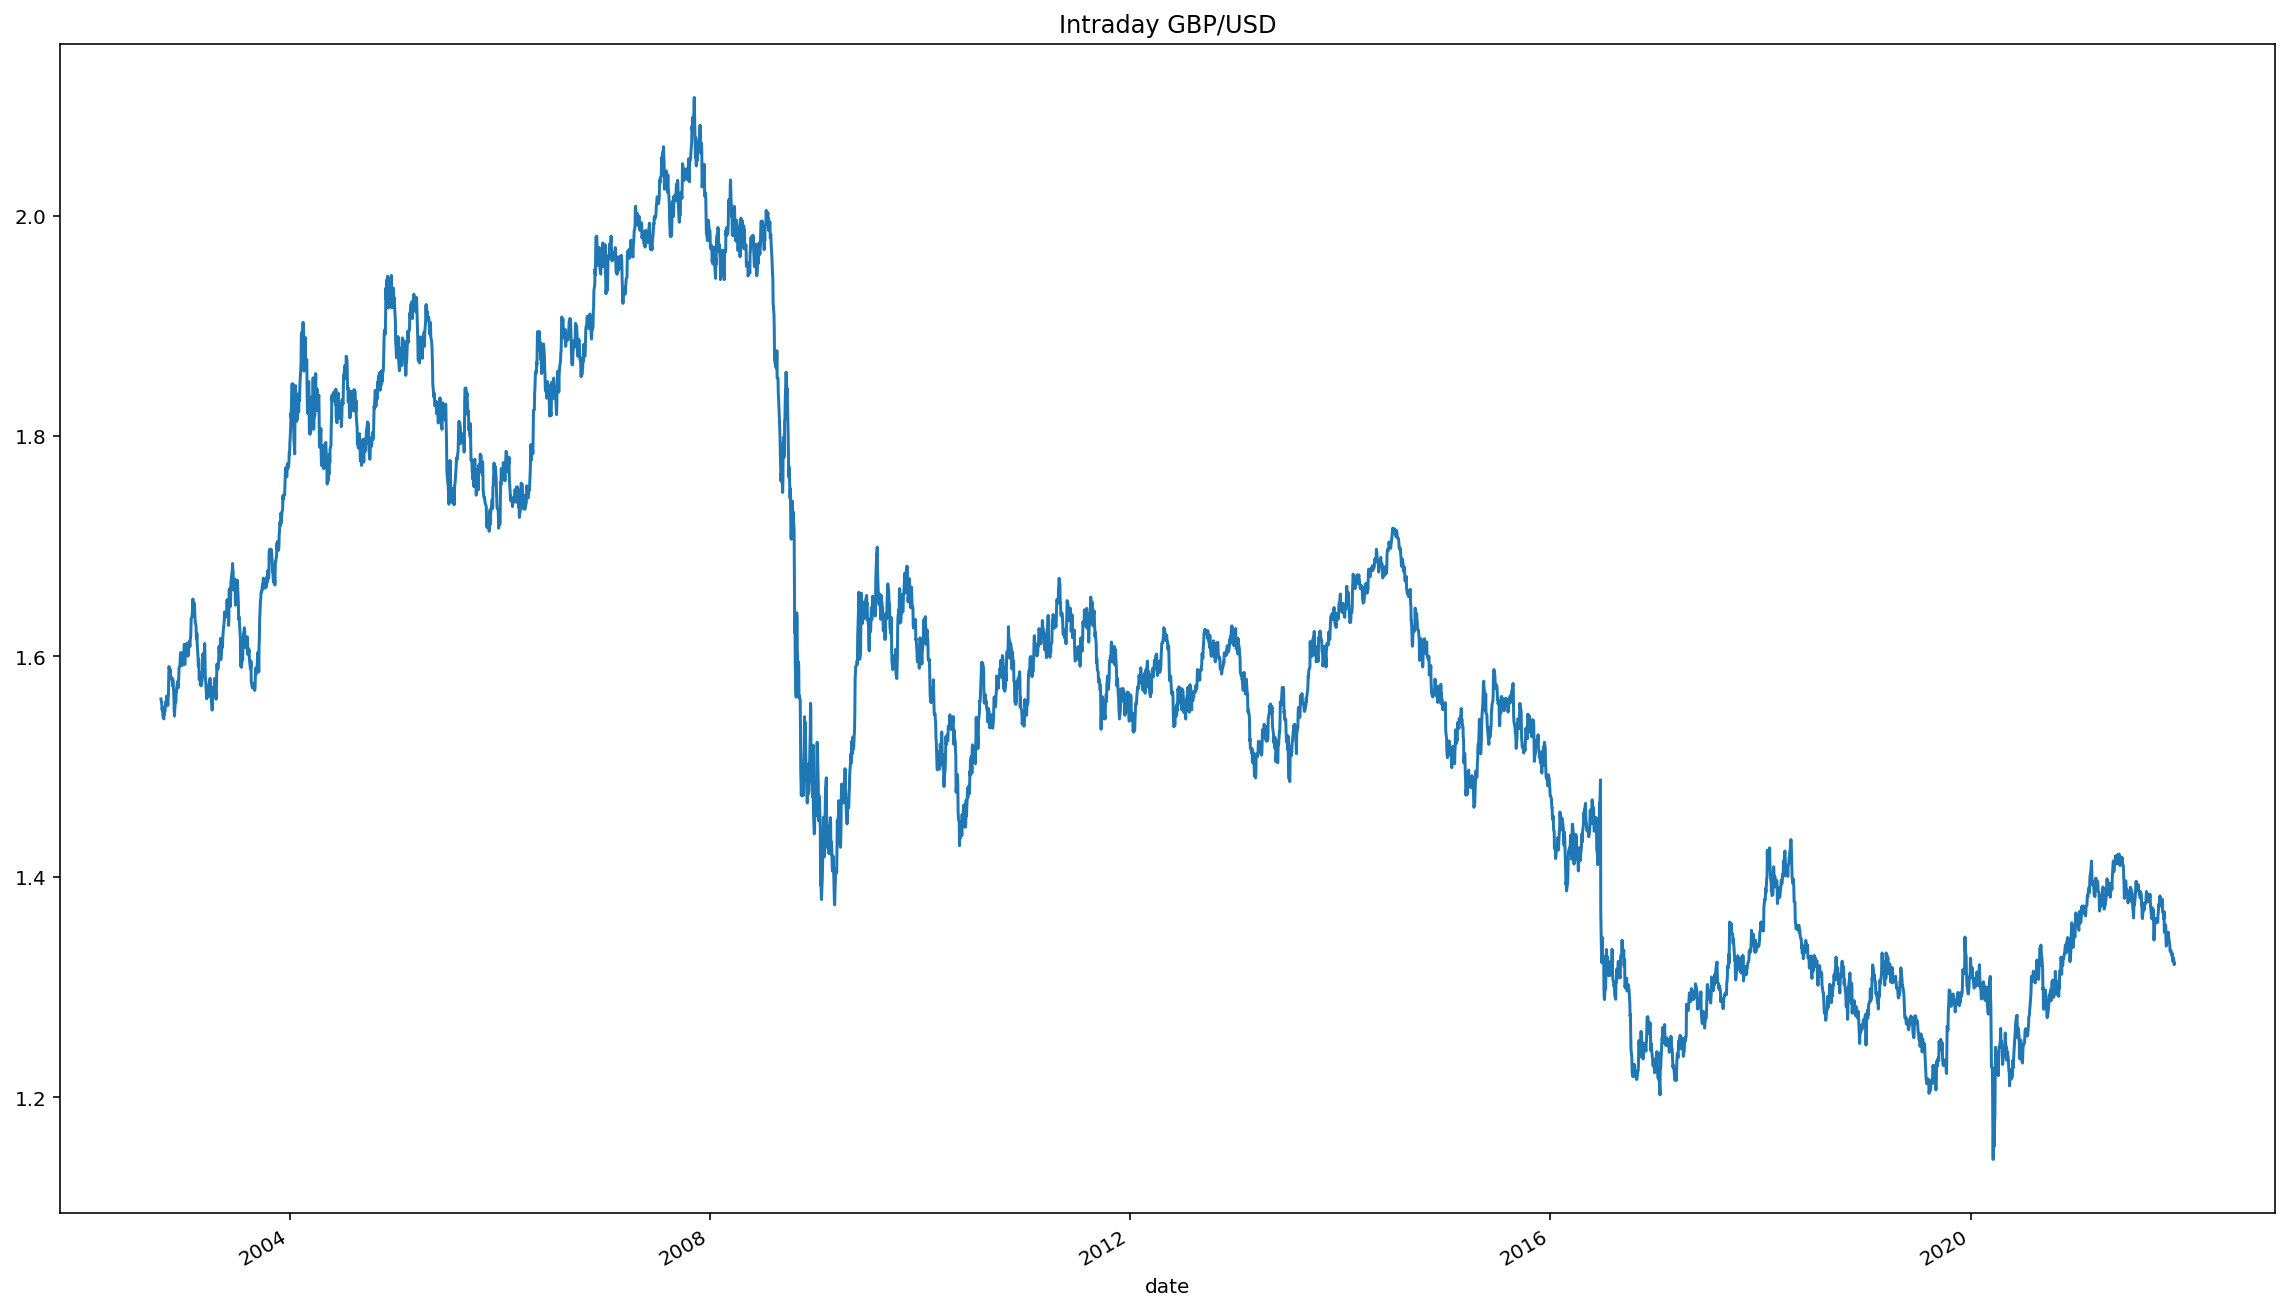

In [19]:
cc = ForeignExchange(key=API_KEY,output_format='pandas')
# We will retrieve daily OHLC prices, Alpha vantage also contains intraday results which are difficult to come by elsewhere
data_df, metadata_df = cc.get_currency_exchange_daily(from_symbol='GBP',to_symbol='USD', outputsize='full')
#Plot what the data looks like
data_df['4. close'].plot()
plt.tight_layout()
plt.title('Intraday GBP/USD')
plt.show()

In [20]:
# Let's just look at 2015 onwards
data_df.sort_index(inplace=True)
data_df = data_df.loc['2015-01-01':]
# Rename & rearrange the fields so they can be ingested by Backtrader
data_df = data_df.loc[:, ['2. high', '3. low', '1. open', '4. close']]
data_df.columns = ['High', 'Low', 'Open', 'Close']

In [38]:
class boll_bander(bt.Strategy):
    # Set a bollinger band indicator, buy when the price exceeds the lower band, sell when price exceeds higher band.
    # Set the parameters for the bollinger band. I chose a 21 day period as that mimics the number of days in a trading month, a smaller standard deviation on the band
    # gives more entry & exit opportunities
    params = dict(
            bperiod=21
            ,dev=1.25)
    
    def __init__(self):

        #Define Bollinger band

        self.boll = bt.ind.BollingerBands(period=self.p.bperiod, devfactor=self.p.dev, plot=True, plotname='Bollinger Band', subplot=False)

        #Define cross-over points

        self.buysig = bt.indicators.CrossOver(self.data0, self.boll.lines.bot, plotname='buy signal', plot=True)
        self.sellsig = bt.indicators.CrossOver(self.data0, self.boll.lines.top,plotname='sell signal', plot=True)
    def next(self):

        if not self.position:  # not in the market
            if self.buysig > 0:  # if fast crosses slow to the upside
                self.order_target_size(target=3000)   # enter long

        elif self.sellsig > 0:  # in the market & cross to the downside
            self.order_target_size(target=0)   # close long position

In [39]:
cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=data_df)
cerebro.adddata(data)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(boll_bander)
results = cerebro.run()

[[<Figure size 1152x648 with 6 Axes>]]

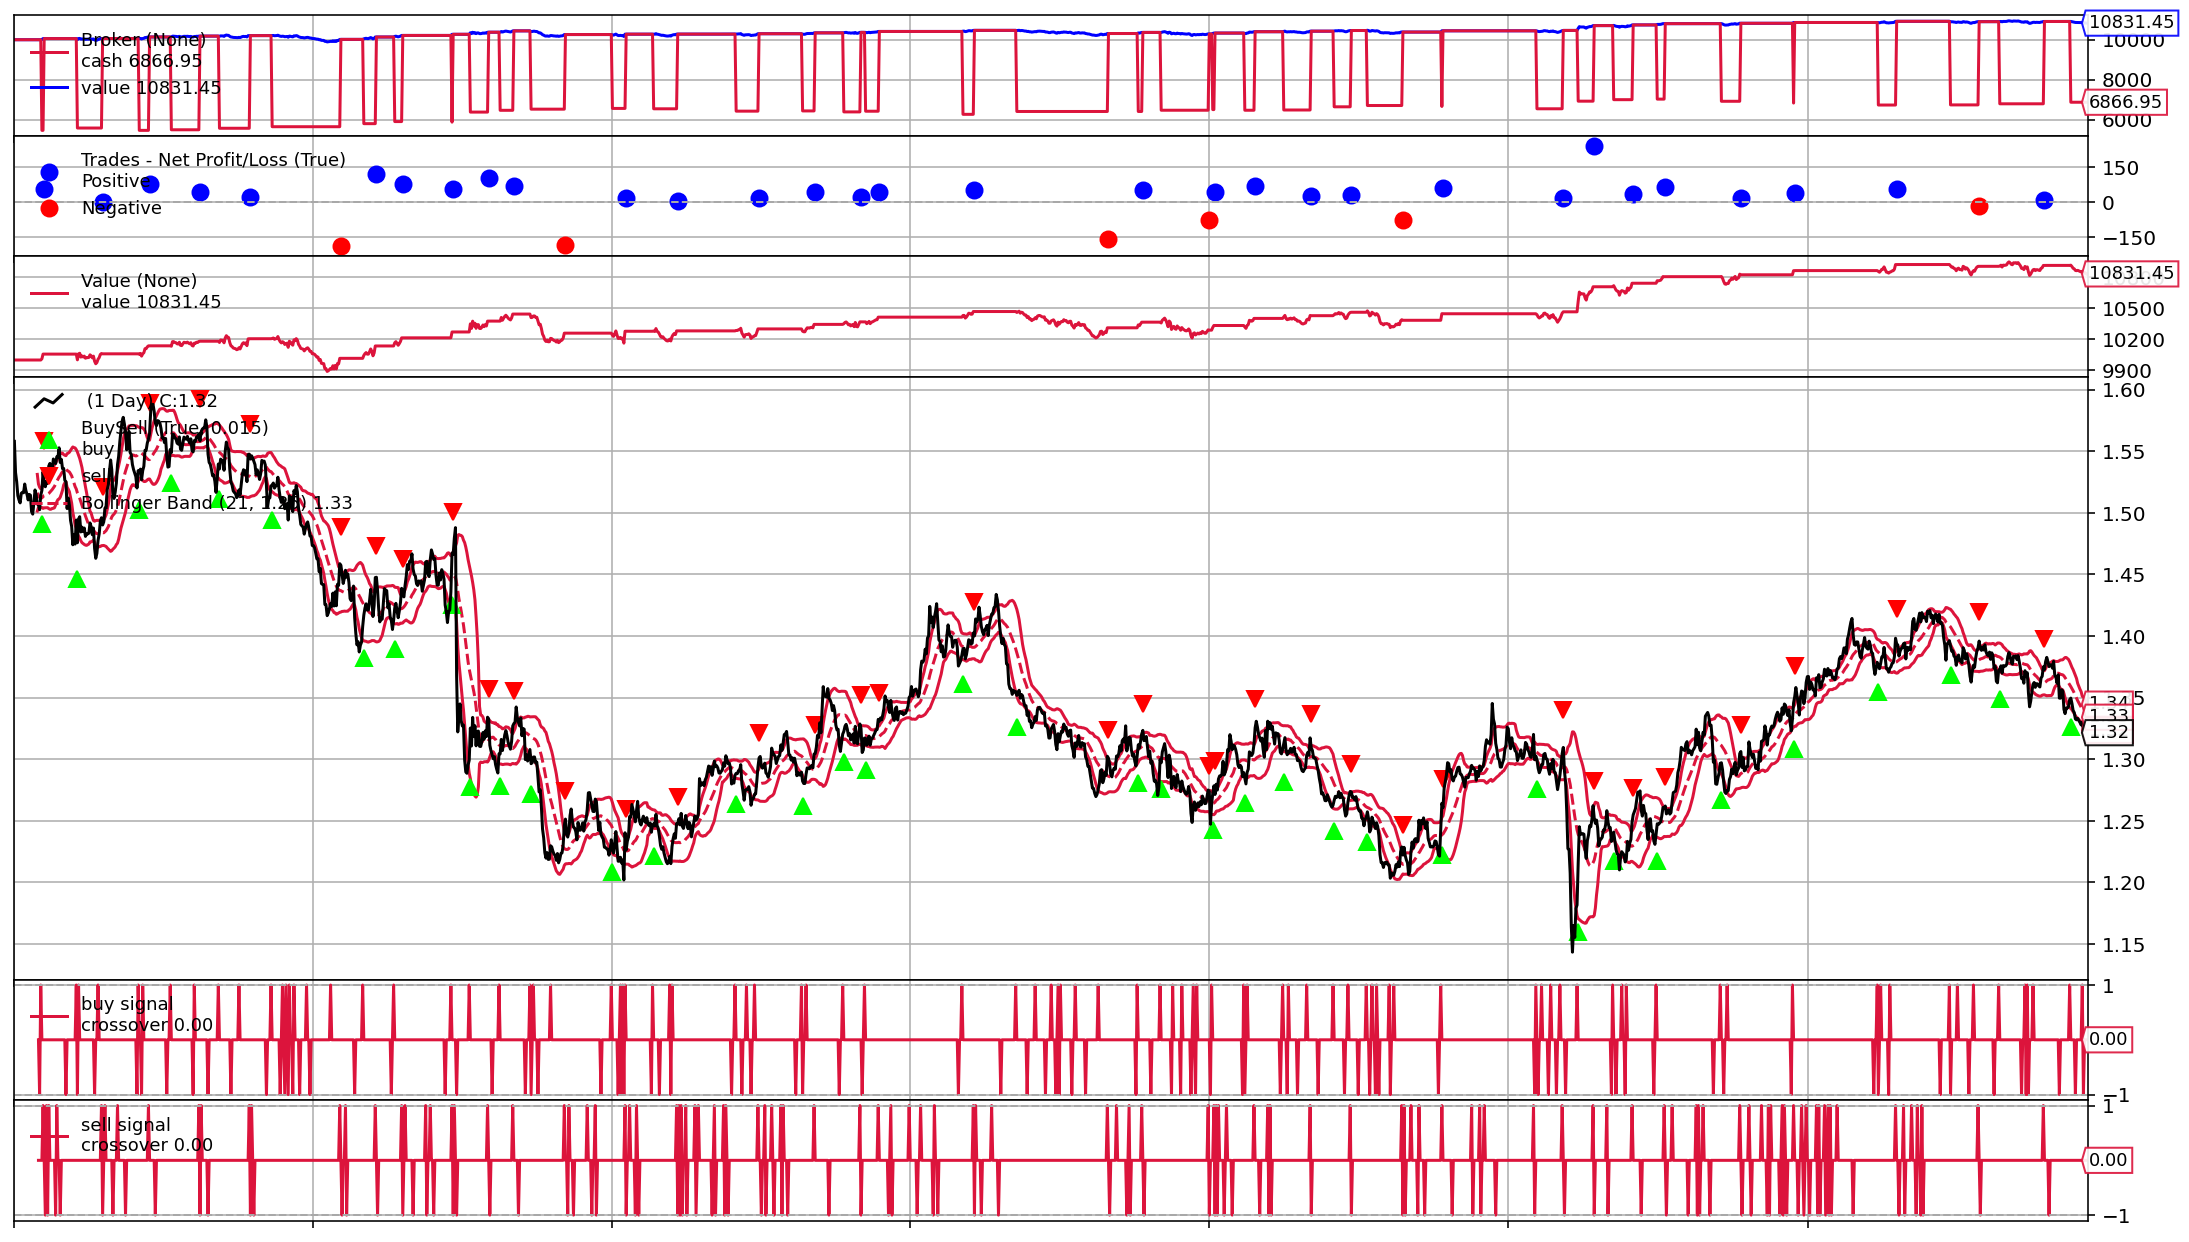

In [40]:
cerebro.plot(iplot=False, volume=False, width=20)

In [41]:
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']}")
print(f'Norm. Annual Return: {results[0].analyzers.returns.get_analysis()["rnorm100"]}')
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']}")


Sharpe: 0.748269112885735
Norm. Annual Return: 1.1175708133763027
Max Drawdown: 3.3720215617095244
